In [3]:
# Import packages
import pathlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0 #MODEL B

### Data

In [8]:
train_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(48_class)/train')
valid_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(48_class)/valid')

In [9]:
# Set Image Dimension (determined by EfficientNet model choice)
IMG_SIZE = 224 # B0=224

# Set Batch Size
BATCH_SIZE = 64

# training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

# validation set
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    label_mode = 'categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 3093 files belonging to 48 classes.
Found 389 files belonging to 48 classes.


In [11]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

for name in CLASS_NAMES:
    print(name)

Ashy Tailorbird
Asian Glossy Starling
Asian Koel
Black-crowned night heron
Black-naped Oriole
Blue-tailed Bee-eater
Blue-throated Bee-eater
Brahminy kite
Brown Shrike
Brown-throated Sunbird
Buffy fish owl
Chinese pond heron
Collared Kingfisher
Common Flameback
Common Iora
Common Kingfisher
Common Myna
Common Tailorbird
Common sandpiper
Coppersmith Barbet
Crested serpent eagle
Eastern cattle egret
Grey heron
Grey-headed fish eagle
Javan Myna
Laced Woodpecker
Little egret
Malaysian Pied Fantail
Olive-backed Sunbird
Oriental Magpie-Robin
Oriental Pied Hornbill
Pacific Swallow
Pink-necked Green Pigeon
Purple heron
Rose-ringed Parakeet
Rufous Woodpecker
Savanna Nightjar
Scarlet-backed Flowerpecker
Spotted wood owl
Stork-billed Kingfisher
Striated heron
Sunda Pygmy Woodpecker
White-bellied sea eagle
White-breasted waterhen
White-throated Kingfisher
Yellow bittern
Yellow-vented Bulbul
Zebra Dove


In [14]:
CLASS_NAMES

['Ashy Tailorbird',
 'Asian Glossy Starling',
 'Asian Koel',
 'Black-crowned night heron',
 'Black-naped Oriole',
 'Blue-tailed Bee-eater',
 'Blue-throated Bee-eater',
 'Brahminy kite',
 'Brown Shrike',
 'Brown-throated Sunbird',
 'Buffy fish owl',
 'Chinese pond heron',
 'Collared Kingfisher',
 'Common Flameback',
 'Common Iora',
 'Common Kingfisher',
 'Common Myna',
 'Common Tailorbird',
 'Common sandpiper',
 'Coppersmith Barbet',
 'Crested serpent eagle',
 'Eastern cattle egret',
 'Grey heron',
 'Grey-headed fish eagle',
 'Javan Myna',
 'Laced Woodpecker',
 'Little egret',
 'Malaysian Pied Fantail',
 'Olive-backed Sunbird',
 'Oriental Magpie-Robin',
 'Oriental Pied Hornbill',
 'Pacific Swallow',
 'Pink-necked Green Pigeon',
 'Purple heron',
 'Rose-ringed Parakeet',
 'Rufous Woodpecker',
 'Savanna Nightjar',
 'Scarlet-backed Flowerpecker',
 'Spotted wood owl',
 'Stork-billed Kingfisher',
 'Striated heron',
 'Sunda Pygmy Woodpecker',
 'White-bellied sea eagle',
 'White-breasted waterh

### Model

In [5]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [6]:
model = build_model(num_classes=NUM_CLASSES)

In [7]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]'

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

### Training Stage 1

In [8]:
epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, 
                 epochs = epochs, 
                 validation_data = valid_ds,
                 verbose=2)

Epoch 1/25
49/49 - 204s - loss: 1.2847 - accuracy: 0.7181 - val_loss: 0.6660 - val_accuracy: 0.8201 - 204s/epoch - 4s/step
Epoch 2/25
49/49 - 176s - loss: 0.3072 - accuracy: 0.9247 - val_loss: 0.4832 - val_accuracy: 0.8638 - 176s/epoch - 4s/step
Epoch 3/25
49/49 - 169s - loss: 0.1618 - accuracy: 0.9567 - val_loss: 0.4893 - val_accuracy: 0.8586 - 169s/epoch - 3s/step
Epoch 4/25
49/49 - 175s - loss: 0.1674 - accuracy: 0.9547 - val_loss: 0.4885 - val_accuracy: 0.8843 - 175s/epoch - 4s/step
Epoch 5/25
49/49 - 138s - loss: 0.1707 - accuracy: 0.9567 - val_loss: 0.5692 - val_accuracy: 0.8792 - 138s/epoch - 3s/step
Epoch 6/25
49/49 - 119s - loss: 0.1635 - accuracy: 0.9644 - val_loss: 0.5903 - val_accuracy: 0.8946 - 119s/epoch - 2s/step
Epoch 7/25
49/49 - 125s - loss: 0.1157 - accuracy: 0.9722 - val_loss: 0.7005 - val_accuracy: 0.8715 - 125s/epoch - 3s/step
Epoch 8/25
49/49 - 90s - loss: 0.1207 - accuracy: 0.9725 - val_loss: 0.6745 - val_accuracy: 0.8997 - 90s/epoch - 2s/step
Epoch 9/25
49/49 -

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

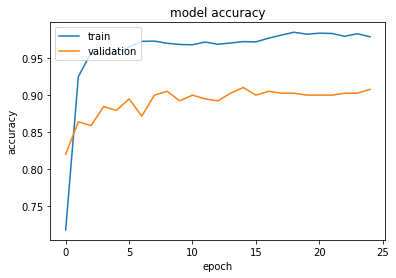

In [10]:
plot_hist(hist)

### Training Stage 2

In [11]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [12]:
unfreeze_model(model)

In [13]:
epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, 
                 epochs = epochs, 
                 validation_data = valid_ds,
                 verbose=2)

Epoch 1/10
49/49 - 85s - loss: 0.0521 - accuracy: 0.9890 - val_loss: 0.9126 - val_accuracy: 0.9229 - 85s/epoch - 2s/step
Epoch 2/10
49/49 - 79s - loss: 0.0507 - accuracy: 0.9913 - val_loss: 0.8701 - val_accuracy: 0.9229 - 79s/epoch - 2s/step
Epoch 3/10
49/49 - 81s - loss: 0.0379 - accuracy: 0.9922 - val_loss: 0.8860 - val_accuracy: 0.9203 - 81s/epoch - 2s/step
Epoch 4/10
49/49 - 85s - loss: 0.0286 - accuracy: 0.9955 - val_loss: 0.9072 - val_accuracy: 0.9152 - 85s/epoch - 2s/step
Epoch 5/10
49/49 - 82s - loss: 0.0139 - accuracy: 0.9964 - val_loss: 0.7938 - val_accuracy: 0.9280 - 82s/epoch - 2s/step
Epoch 6/10
49/49 - 81s - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.8426 - val_accuracy: 0.9306 - 81s/epoch - 2s/step
Epoch 7/10
49/49 - 82s - loss: 0.0306 - accuracy: 0.9935 - val_loss: 0.7747 - val_accuracy: 0.9229 - 82s/epoch - 2s/step
Epoch 8/10
49/49 - 87s - loss: 0.0158 - accuracy: 0.9968 - val_loss: 0.8156 - val_accuracy: 0.9203 - 87s/epoch - 2s/step
Epoch 9/10
49/49 - 82s - loss: 0

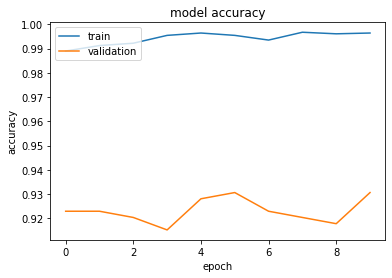

In [14]:
plot_hist(hist)

### Save Model

In [15]:
model.save('D:\\University\\CS3244\\Project\\EfficientNet\\saved_model\\model_B0SL48nad')

INFO:tensorflow:Assets written to: D:\University\CS3244\Project\EfficientNet\saved_model\model_B0SL48nad\assets


### Evaluation

In [6]:
test_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(48_class)/test')

In [6]:
# Function to process and predict image
def image_prediction(image):
    # Process input image
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.expand_dims(image_resized, axis=0)
    
    # Threshold
    threshold = (1/NUM_CLASSES) * 1.2 # 120% from uniform split probability as threshold
    
    # Run image through model to obtain prediction
    pred = model.predict(image)
        # pred is a array of length class_count. Each entry is the probability for a particular class
        # Index based on class_names
        
    if pred[0][np.argmax(pred)] < threshold:
        pred_class = "Unknown"
        
    else:    
        # Obtain prediction class
        pred_class = CLASS_NAMES[np.argmax(pred)]
    
    return pred_class

In [8]:
total_count   = [0] * NUM_CLASSES
true_positive = [0] * NUM_CLASSES
false_negative = [0] * NUM_CLASSES
false_positive = [0] * NUM_CLASSES
unknown_count = 0

for bird_folder in test_dir.rglob("*"):
    for bird_image in bird_folder.rglob("*.jpg"):
        
        bird_species = str(bird_folder.stem)
        bird_index = CLASS_NAMES.index(bird_species)
        
        # Update total count
        total_count[bird_index] += 1
        
        # Load image
        image = cv2.imread(str(bird_image))
        
        # Predict classification
        pred_class = image_prediction(image)
        # print(pred_class)
        
        if str(pred_class) == bird_species:
            true_positive[bird_index] += 1
            
        elif str(pred_class) == "Unknown":
            unknown_count += 1
            
        else:
            false_negative[bird_index] += 1  
            false_positive[CLASS_NAMES.index(pred_class)] += 1

In [9]:
unknown_count

0

In [10]:
results = pd.DataFrame({'Class': CLASS_NAMES,
                        'total': total_count,
                        'true_positive' : true_positive,
                        'false_negative' : false_negative,
                        'false_positive' : false_positive})

In [11]:
results['Precision'] = results['true_positive']/(results['true_positive']+results['false_positive'])
results['Recall'] = results['true_positive']/(results['true_positive']+results['false_negative'])
results['F1 Score'] = (2/((1/results['Precision'])+(1/results['Recall'])))

In [12]:
results

,Class,total,true_positive,false_negative,false_positive,Precision,Recall,F1 Score
0,Ashy Tailorbird,9,1,8,1,0.500000,0.111111,0.181818
1,Asian Glossy Starling,8,3,5,4,0.428571,0.375000,0.400000
2,Asian Koel,7,1,6,10,0.090909,0.142857,0.111111
3,Black-crowned night heron,8,2,6,1,0.666667,0.250000,0.363636
4,Black-naped Oriole,7,2,5,2,0.500000,0.285714,0.363636
5,Blue-tailed Bee-eater,8,2,6,10,0.166667,0.250000,0.200000
6,Blue-throated Bee-eater,10,5,5,21,0.192308,0.500000,0.277778
7,Brahminy kite,8,2,6,7,0.222222,0.250000,0.235294
8,Brown Shrike,8,7,1,2,0.777778,0.875000,0.823529
9,Brown-throated Sunbird,10,7,3,8,0.466667,0.700000,0.560000


In [13]:
filepath = pathlib.Path('D:/University/CS3244/Project/EfficientNet/Results CSV/EfficientNet_BASE.csv') 
results.to_csv(filepath, index = False) 

In [5]:
# Reloading model from save
model = tf.keras.models.load_model('D:\\University\\CS3244\\Project\\EfficientNet\\saved_model\\model_B0SL48nad')

### Time Evaluation

In [12]:
import time

test_image_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(48_class)/test/Ashy Tailorbird/02a46396a0.jpg')
test_image = cv2.imread(str(test_image_dir))

tic = time.perf_counter()

test_pred_class = image_prediction(test_image)

t = time.perf_counter() - tic
print(t, ' seconds')
print(test_pred_class)

0.9722002000000032  seconds
Malaysian Pied Fantail
